# Problem 3: Coin Detection (Simple Final Pipeline)

This notebook applies a fixed perspective warp, runs Hough circle detection on the warped image, and back-projects the detected circles as contours onto the original image.


In [1]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# Load image
coins_image_path = os.path.join('imgs', 'coins2.jpg')
coins_image = cv2.imread(coins_image_path)

if coins_image is None:
    raise FileNotFoundError(f'Could not load image: {coins_image_path}')

h_img, w_img = coins_image.shape[:2]



Detected coins: 48
Warped canvas size: 938 x 758
Hough blur: k=9, sigma=2.0


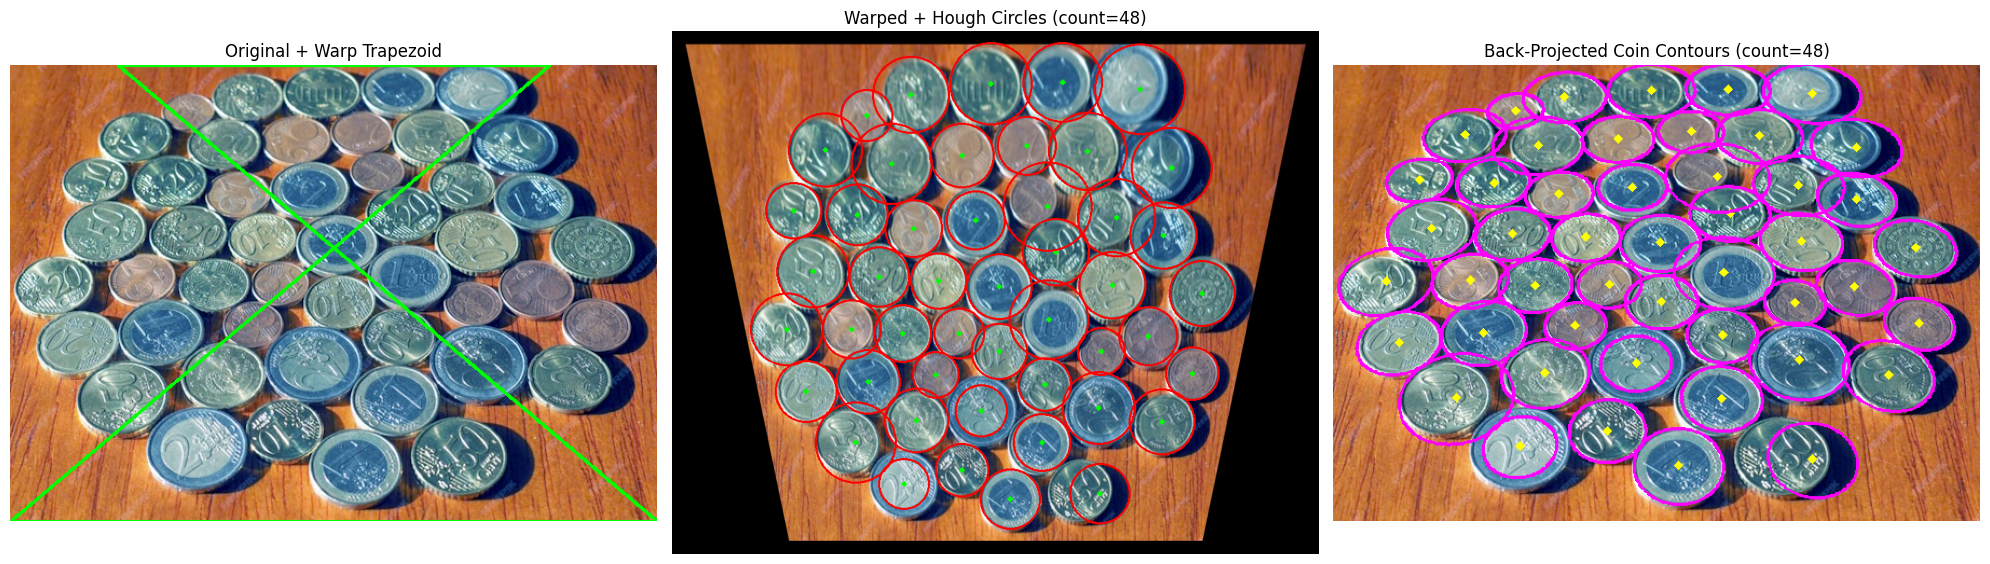

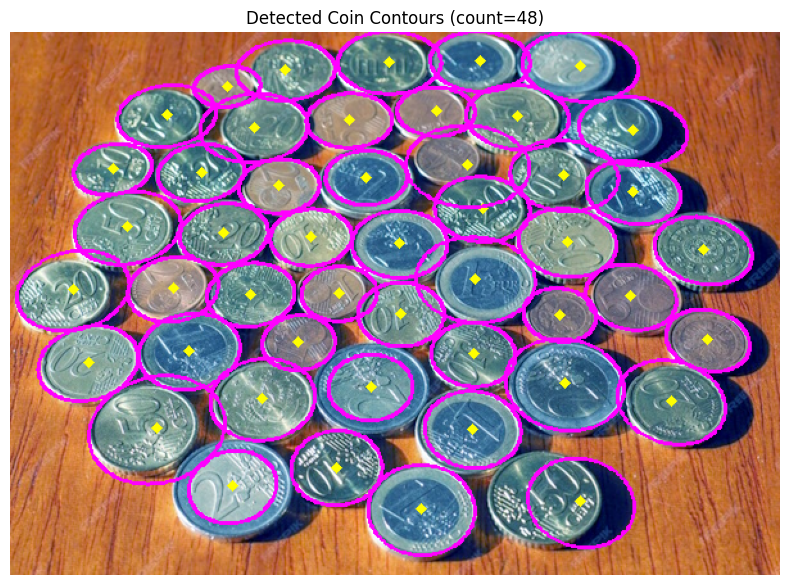

Saved titled output figure to: output/coins_detected_backprojected_count.png
Saved raw overlay image to: output/coins_detected_backprojected_overlay_raw.png


In [3]:
# Final chosen settings (warp + Hough)
pts_src = np.float32([
    [100, 0],
    [500, 0],
    [0, 423],
    [600, 423],
])
warp_w, warp_h = 600, 720
pad = 20

# Hough params
dp = 1.0
minDist = 60
param1 = 90
param2 = 23
minRadius = 25
maxRadius = 66
blur_k = 9
blur_sigma = 2.0
contour_samples = 120

def warp_with_auto_canvas(image, pts_src, rect_w, rect_h, pad=0):
    """Perspective warp with translated output canvas so source pixels are not cropped."""
    h_img, w_img = image.shape[:2]
    pts_src = np.asarray(pts_src, dtype=np.float32)
    pts_dst = np.float32([
        [0, 0],
        [rect_w - 1, 0],
        [0, rect_h - 1],
        [rect_w - 1, rect_h - 1],
    ])

    H_base = cv2.getPerspectiveTransform(pts_src, pts_dst)

    src_corners = np.float32([
        [0, 0],
        [w_img - 1, 0],
        [w_img - 1, h_img - 1],
        [0, h_img - 1],
    ]).reshape(-1, 1, 2)

    warped_corners = cv2.perspectiveTransform(src_corners, H_base).reshape(-1, 2)
    min_xy = np.floor(warped_corners.min(axis=0) - pad)
    max_xy = np.ceil(warped_corners.max(axis=0) + pad)

    out_w = max(1, int(max_xy[0] - min_xy[0]))
    out_h = max(1, int(max_xy[1] - min_xy[1]))

    T = np.array([
        [1, 0, -min_xy[0]],
        [0, 1, -min_xy[1]],
        [0, 0, 1],
    ], dtype=np.float32)

    H_full = T @ H_base  # original -> warped canvas
    H_inv = np.linalg.inv(H_full).astype(np.float32)  # warped canvas -> original

    warped = cv2.warpPerspective(
        image,
        H_full,
        (out_w, out_h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0),
    )

    return warped, H_full, H_inv, (out_w, out_h)


def detect_hough_circles(img_bgr, dp, minDist, param1, param2, minRadius, maxRadius,
                         blur_k=9, blur_sigma=2.0):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur_k = max(1, int(blur_k))
    if blur_k % 2 == 0:
        blur_k += 1
    gray_blur = cv2.GaussianBlur(gray, (blur_k, blur_k), blur_sigma)

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=float(dp),
        minDist=float(minDist),
        param1=float(param1),
        param2=float(param2),
        minRadius=int(minRadius),
        maxRadius=int(maxRadius),
    )
    return gray_blur, circles


def circle_contour_backproject(circle_xyr, H_inv, samples=120):
    """Sample a circle in warped space and map samples back to original perspective."""
    x, y, r = [float(v) for v in circle_xyr]
    theta = np.linspace(0, 2 * np.pi, samples, endpoint=False, dtype=np.float32)
    pts = np.stack([
        x + r * np.cos(theta),
        y + r * np.sin(theta)
    ], axis=1).astype(np.float32).reshape(-1, 1, 2)

    contour_orig = cv2.perspectiveTransform(pts, H_inv).reshape(-1, 2)
    center_orig = cv2.perspectiveTransform(
        np.array([[[x, y]]], dtype=np.float32), H_inv
    ).reshape(2)
    return contour_orig, center_orig


def draw_trapezoid(image, pts_src):
    out = image.copy()
    pts_int = np.int32(np.round(pts_src)).reshape(-1, 1, 2)
    cv2.polylines(out, [pts_int], True, (0, 255, 0), 2)
    return out


warped_coins_image, matrix, matrix_inv, warped_size = warp_with_auto_canvas(
    coins_image, pts_src, warp_w, warp_h, pad=pad
)

gray_blur, circles = detect_hough_circles(
    warped_coins_image,
    dp=dp,
    minDist=minDist,
    param1=param1,
    param2=param2,
    minRadius=minRadius,
    maxRadius=maxRadius,
    blur_k=blur_k,
    blur_sigma=blur_sigma,
)

warped_overlay = warped_coins_image.copy()
backprojected_overlay = coins_image.copy()

circles_float = []
if circles is not None:
    circles_float = circles[0].astype(np.float32)

for x, y, r in circles_float:
    # Draw circle in warped image
    cv2.circle(warped_overlay, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
    cv2.circle(warped_overlay, (int(round(x)), int(round(y))), 2, (0, 255, 0), 3)

    # Back-project detected circle contour to original perspective
    contour_orig_f, center_orig_f = circle_contour_backproject((x, y, r), matrix_inv, samples=contour_samples)
    contour_orig = np.int32(np.round(contour_orig_f)).reshape(-1, 1, 2)
    cv2.polylines(backprojected_overlay, [contour_orig], True, (255, 0, 255), 2)

    cx0, cy0 = int(round(center_orig_f[0])), int(round(center_orig_f[1]))
    cv2.circle(backprojected_overlay, (cx0, cy0), 2, (0, 255, 255), 3)

coin_count = len(circles_float)
print(f'Detected coins: {coin_count}')
print(f'Warped canvas size: {warped_size[0]} x {warped_size[1]}')
print(f'Hough blur: k={blur_k}, sigma={blur_sigma}')

# Show results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(cv2.cvtColor(draw_trapezoid(coins_image, pts_src), cv2.COLOR_BGR2RGB))
axes[0].set_title('Original + Warp Trapezoid')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(warped_overlay, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Warped + Hough Circles (count={coin_count})')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(backprojected_overlay, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Back-Projected Coin Contours (count={coin_count})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

output_fig_path = os.path.join('output', 'coins_detected_backprojected_count.png')

fig_out = plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(backprojected_overlay, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Coin Contours (count={coin_count})')
plt.axis('off')
plt.tight_layout()
fig_out.savefig(output_fig_path, dpi=200, bbox_inches='tight')
plt.show()

# Optional raw overlay image export (no matplotlib title baked in)
output_raw_path = os.path.join('output', 'coins_detected_backprojected_overlay_raw.png')
cv2.imwrite(output_raw_path, backprojected_overlay)

print(f'Saved titled output figure to: {output_fig_path}')
print(f'Saved raw overlay image to: {output_raw_path}')

